In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b7b056e0b31ab3d00b464f8023a7a65d7b163d58db3c06fe0d0465372555e71b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
#Packages to be downloaded

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.functions import col,sum,rank,row_number,mean,when
from pyspark.sql.functions import corr

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
import pyspark.sql.functions as F


import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


In [ ]:
sc = SparkContext.getOrCreate()
#Inititating Spark Session
spark = SparkSession\
    .builder\
    .appName('Countries GDP Analysis')\
    .getOrCreate()

In [ ]:
#Joining 2 data frames
df1 = spark.read.csv("/content/Countries.csv", header=True, inferSchema=True)
df2 = spark.read.csv("/content/Countries2.csv", header=True, inferSchema=True)
df2 = df2.withColumnRenamed('Time', 'Year')
df2 = df2.withColumnRenamed('Country Code', 'Country_Code')
countries_df = df1.join(df2, on=["Country Name","Year"])

In [ ]:
countries_df.show()

+------------+----+------------+-------------------+----------------------+-----------------------------+--------------+--------------------+--------------------------+--------------+-----------------+------------------+----+-----------------+------------+-----------+--------+--------------+------+------+---------------------+--------------------+---------+------------------+------------------+------------+---------+---------------------------------------------------+------------------------------------------------------------------------+-------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------+
|Country Name|Year|Country Code|Agriculture (% GDP)|Ease of Doing Business|Education Expenditure (% GDP)|Export (% GDP)|                 GDP|Health Expenditure (% GDP)|Import (% GDP)| Industry (% GDP)|    Inflation Rate| R&D|  Service (% GDP)|Unemployment| Population|    Land|Conti

In [ ]:
# Rename columns
# Syntax: df = df.withColumnRenamed('existing_column_name', 'new_column_name')
countries_df = countries_df.withColumnRenamed('Military expenditure (% of GDP) [MS.MIL.XPND.GD.ZS]', 'Military expenditure(% of GDP)')
countries_df = countries_df.withColumnRenamed('Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]','FDI net inflows(% of GDP)')
countries_df = countries_df.withColumnRenamed('Foreign direct investment, net outflows (% of GDP) [BM.KLT.DINV.WD.GD.ZS]','FDI net outflows(% of GDP)')
countries_df = countries_df.withColumnRenamed('Tax revenue (% of GDP) [GC.TAX.TOTL.GD.ZS]','Tax revenue(% of GDP)')
countries_df = countries_df.withColumnRenamed('Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]','Inflation consumer prices(annual %)')

In [ ]:
countries_df = countries_df.dropDuplicates()

In [ ]:
countries_df = countries_df.drop("Time Code")
countries_df = countries_df.drop("Country_Code")

In [ ]:
# Calculating Contributions for columns
countries_df = countries_df.withColumnRenamed("Unemployment", "Unemployment (%)")

countries_df = countries_df.withColumn("Total Unemployed",
                                         (col("Unemployment (%)") / 100) * col("Population"))
countries_df = countries_df.withColumn("Agriculture Contribution($)",
                                         (col("Agriculture (% GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("Industry Contribution($)",
                                         (col("Industry (% GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("Service Contribution($)",
                                         (col("Service (% GDP)") / 100) * col("GDP"))

In [ ]:
countries_df = countries_df.withColumn("Miltary Expenditure",
                                         (col("Military expenditure(% of GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("FDI net inflows",
                                         (col("FDI net inflows(% of GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("FDI net outflows",
                                         (col("FDI net outflows(% of GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("Tax revenue",
                                         (col("Tax revenue(% of GDP)") / 100) * col("GDP"))
countries_df = countries_df.withColumn("Inflation consumer prices",
                                         (col("Inflation consumer prices(annual %)") / 100) * col("GDP"))

In [ ]:
countries_df.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Agriculture (% GDP): double (nullable = true)
 |-- Ease of Doing Business: double (nullable = true)
 |-- Education Expenditure (% GDP): double (nullable = true)
 |-- Export (% GDP): double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Health Expenditure (% GDP): double (nullable = true)
 |-- Import (% GDP): double (nullable = true)
 |-- Industry (% GDP): double (nullable = true)
 |-- Inflation Rate: double (nullable = true)
 |-- R&D: double (nullable = true)
 |-- Service (% GDP): double (nullable = true)
 |-- Unemployment (%): double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Land: double (nullable = true)
 |-- Continent Name: string (nullable = true)
 |-- Export: double (nullable = true)
 |-- Import: double (nullable = true)
 |-- Education Expenditure: double (nullable = true)
 |-- Health Expenditure: double (nullable 

In [ ]:
# List of column names to convert
columns_to_convert = [
    "Military expenditure(% of GDP)",
    "FDI net inflows(% of GDP)",
    "FDI net outflows(% of GDP)",
    "Tax revenue(% of GDP)",
    "Inflation consumer prices(annual %)"
]

# Convert each column from string to double
for column in columns_to_convert:
    countries_df = countries_df.withColumn(column, col(column).cast("double"))

In [ ]:
countries_df = countries_df.withColumn("GDP", col("GDP").cast("double"))

gdp_df = countries_df.sort(col("GDP").desc())
gdp_df.show(10)

+-------------+----+------------+-------------------+----------------------+-----------------------------+------------------+-------------------+--------------------------+------------------+------------------+-----------------+--------------------+-----------------+----------------+------------+-----------------+--------------+--------------------+--------------------+---------------------+--------------------+--------------------+------------------+------------------+------------------------------+-------------------------+--------------------------+---------------------+-----------------------------------+--------------------+---------------------------+------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+
| Country Name|Year|Country Code|Agriculture (% GDP)|Ease of Doing Business|Education Expenditure (% GDP)|    Export (% GDP)|                GDP|Health Expenditure (% GDP)|   

In [ ]:
# Counting null values for each country in each column
null_counts = countries_df.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in countries_df.columns]
)

# Converting to Pandas DataFrame for visualization
null_counts_pandas = null_counts.toPandas()

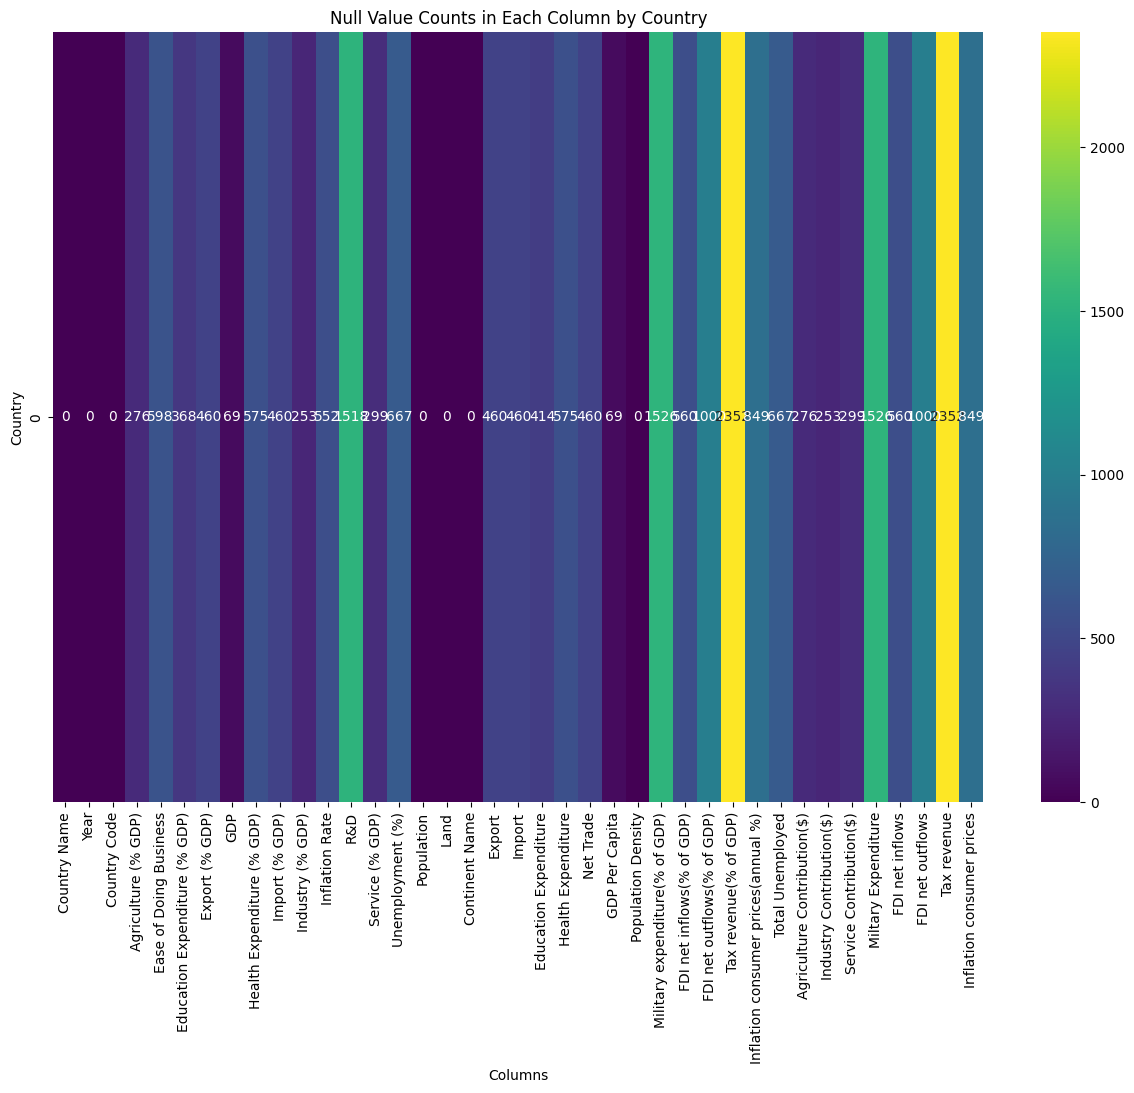

In [ ]:
# Setting the figure size and style for better readability
plt.figure(figsize=(15, 10))
sns.heatmap(null_counts_pandas, annot=True, cmap='viridis', fmt='d')

# Setting titles and labels
plt.title('Null Value Counts in Each Column by Country')
plt.ylabel('Country')
plt.xlabel('Columns')

# Display the heatmap
plt.show()

In [ ]:
#mean imputation
mean_values_df = countries_df.groupBy("Continent Name").agg(
    *(mean(c).alias(f"{c}_mean") for c in countries_df.columns if c not in ["Country Name", "Continent Name"])
)

#Joining the mean values with the original DataFrame
countries_df_with_mean = countries_df.join(mean_values_df, "Continent Name")

#Applying mean imputation only for null values
for column in countries_df.columns:
    if column not in ["Country Name", "Continent Name"]:
        mean_column = f"{column}_mean"
        countries_df_with_mean = countries_df_with_mean.withColumn(
            column,
            when(
                col(column).isNull(),
                col(mean_column)
            ).otherwise(col(column))
        )

# Dropping the mean columns after imputation
for mean_column in mean_values_df.columns:
    if mean_column != "Continent Name":
        countries_df_with_mean = countries_df_with_mean.drop(mean_column)

print("DataFrame after mean imputation:")
countries_df_with_mean.show()

DataFrame after mean imputation:
+--------------+---------------+------+------------+-------------------+----------------------+-----------------------------+----------------+-------------------+--------------------------+----------------+------------------+-----------------+--------------------+-----------------+----------------+------------+---------+--------------------+--------------------+---------------------+--------------------+--------------------+------------------+------------------+------------------------------+-------------------------+--------------------------+---------------------+-----------------------------------+--------------------+---------------------------+------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+
|Continent Name|   Country Name|  Year|Country Code|Agriculture (% GDP)|Ease of Doing Business|Education Expenditure (% GDP)|  Export (% GDP)|        

In [ ]:
countries_df_with_mean = countries_df_with_mean.withColumn('Year', col('Year').cast("Int"))

#Education, unemployment and Inflation Rate analysis

In [ ]:
# Calculate the correlation between two columns
correlation = countries_df.select(corr("Total Unemployed", "Inflation Rate")).collect()[0][0]

# Print the correlation value
print(correlation)

0.007083925333792597


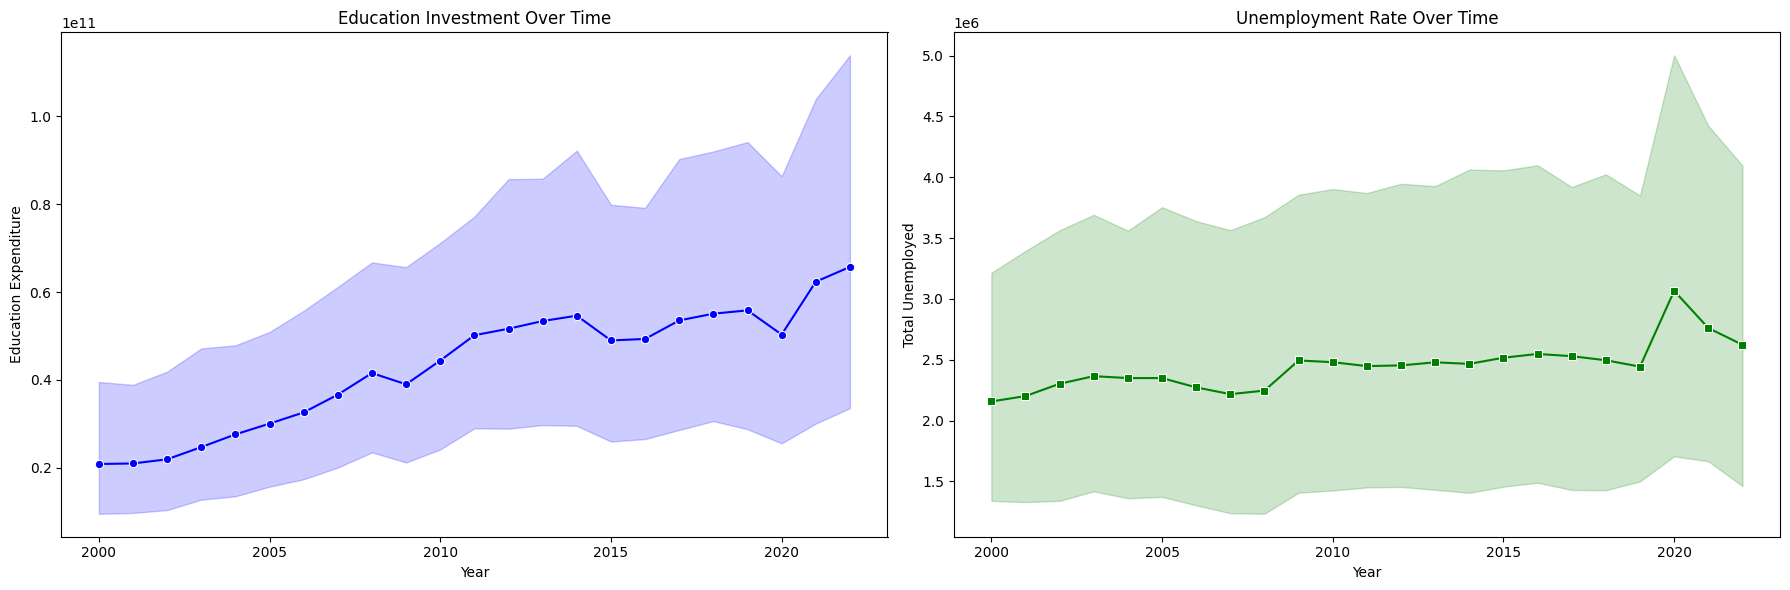

In [ ]:
pdf = countries_df.toPandas()
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot Education Investment over time on the first subplot
sns.lineplot(ax=axes[0], data=pdf, x='Year', y='Education Expenditure', marker='o', color='blue')
axes[0].set_title('Education Investment Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Education Expenditure')

# Plot Unemployment Rate over time on the second subplot
sns.lineplot(ax=axes[1], data=pdf, x='Year', y='Total Unemployed', marker='s', color='green')
axes[1].set_title('Unemployment Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Unemployed')

plt.tight_layout()
plt.show()

In [ ]:
# Filter the DataFrame for years 2000 to 2022
unemploy_df = countries_df.filter((col("Year") >= 2000) & (col("Year") <= 2022))

# Group by country and calculate the average unemployment rate
unemploy_grouped = unemploy_df.groupBy("Country Name").agg({"Total Unemployed": "avg"})

# Sort by the average unemployment rate in descending order and take the top 5
top_5_unemploy = unemploy_grouped.orderBy(col("avg(Total Unemployed)").desc()).limit(3)

In [ ]:
top_5_countries_list = [row['Country Name'] for row in top_5_unemploy.collect()]

In [ ]:
filtered_df = countries_df.filter(
    (countries_df['Country Name'].isin(top_5_countries_list)) &
    (countries_df['Year'] >= 2000) &
    (countries_df['Year'] <= 2022)
)

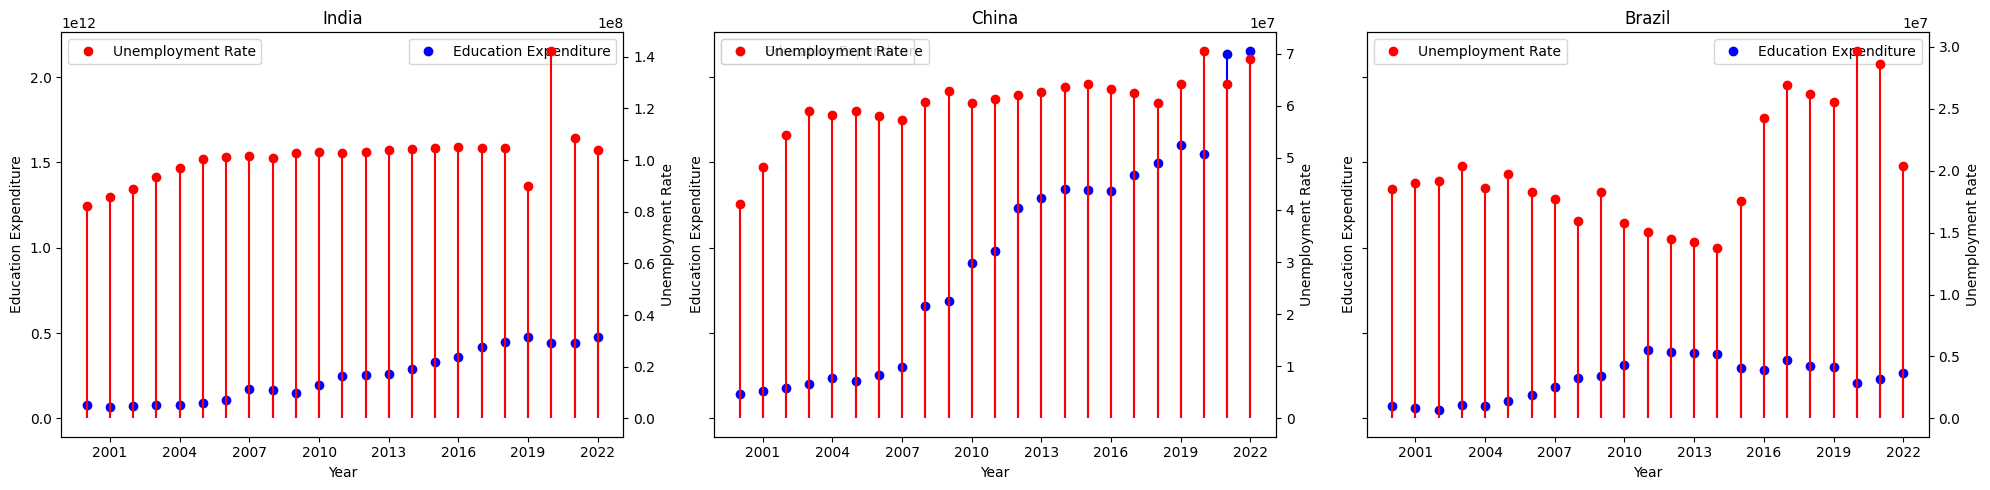

In [ ]:
plt_df = filtered_df.toPandas()
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=len(top_5_countries_list), figsize=(20, 5), sharey='row')

for i, country in enumerate(top_5_countries_list):
    ax = axes[i]
    country_data = plt_df[plt_df['Country Name'] == country]

    # Lollipop plot for education expenditure
    (markers, stemlines, baseline) = ax.stem(country_data['Year'], country_data['Education Expenditure'], linefmt='b-', markerfmt='bo', basefmt=" ")
    ax.set_label('Education Expenditure')

    # Create a secondary Y-axis for unemployment rate
    ax2 = ax.twinx()

    # Lollipop plot for unemployment rate on the secondary Y-axis
    (markers2, stemlines2, baseline2) = ax2.stem(country_data['Year'], country_data['Total Unemployed'], linefmt='r-', markerfmt='ro', basefmt=" ")
    ax2.set_label('Unemployment Rate')

    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Education Expenditure')
    ax2.set_ylabel('Unemployment Rate')

    # Handling overlapping x-axis labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Adding legends
    ax.legend(handles=[markers], labels=['Education Expenditure'])
    ax2.legend(handles=[markers2], labels=['Unemployment Rate'], loc='upper left')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

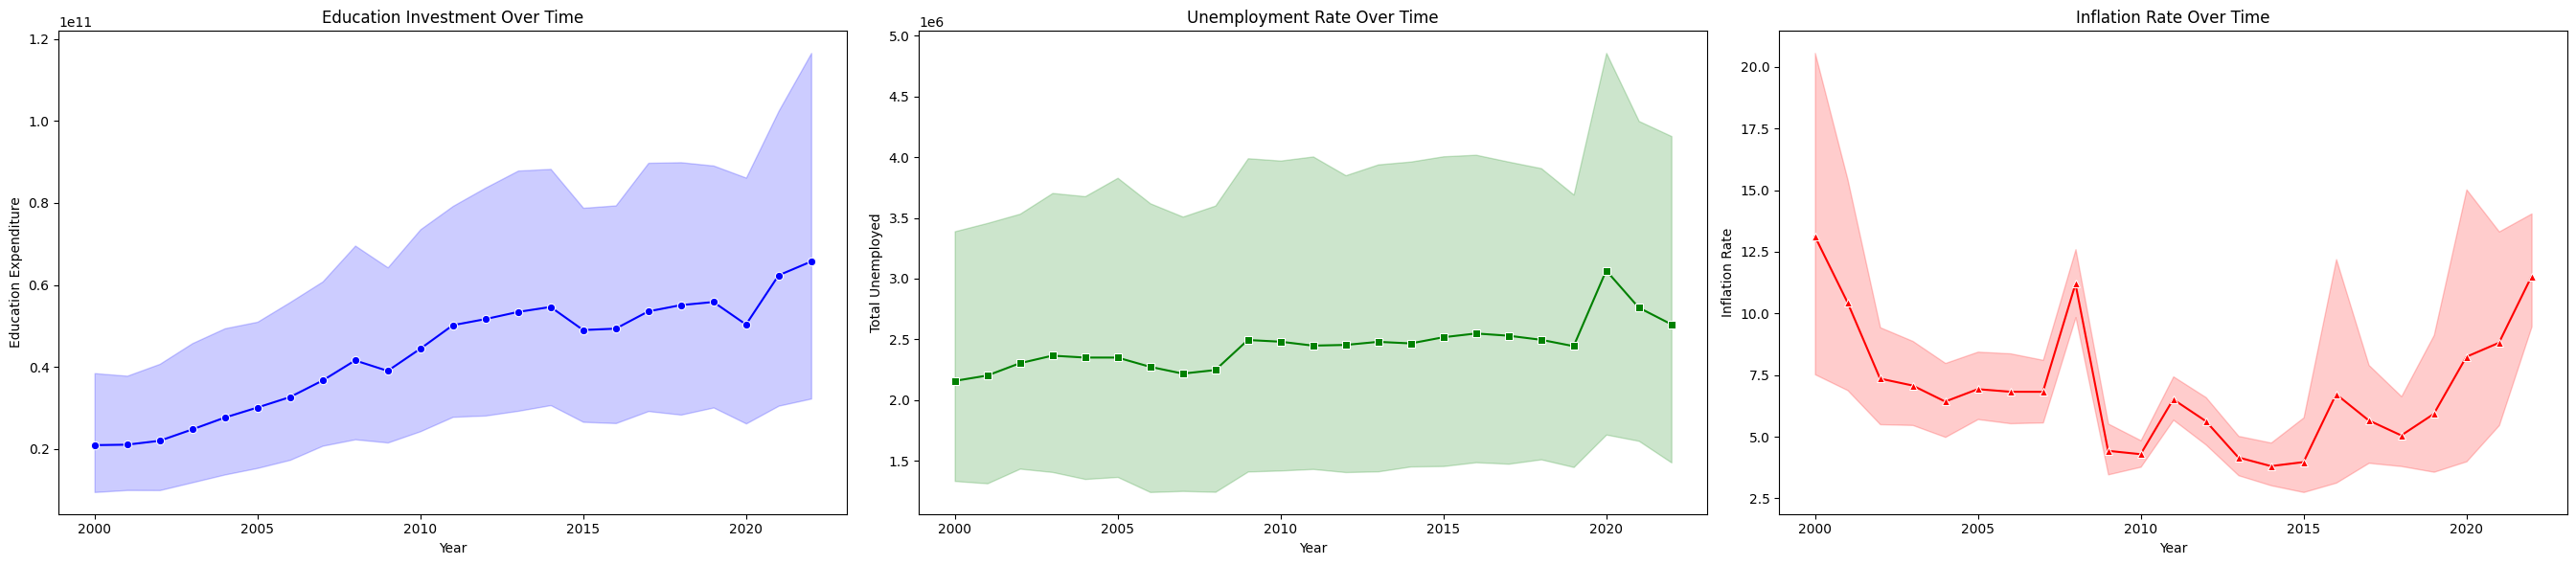

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(27, 6))  # Adjusted for three subplots

# Plotting Education Investment over time on the first subplot
sns.lineplot(ax=axes[0], data=pdf, x='Year', y='Education Expenditure', marker='o', color='blue')
axes[0].set_title('Education Investment Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Education Expenditure')

# Plotting Unemployment Rate over time on the second subplot
sns.lineplot(ax=axes[1], data=pdf, x='Year', y='Total Unemployed', marker='s', color='green')
axes[1].set_title('Unemployment Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Unemployed')

# Plotting Inflation Rate over time on the third subplot
sns.lineplot(ax=axes[2], data=pdf, x='Year', y='Inflation Rate', marker='^', color='red')
axes[2].set_title('Inflation Rate Over Time')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Inflation Rate')

plt.tight_layout()
plt.show()


#Education and Health Expenditure Analysis

In [ ]:

grouped_df = countries_df.groupBy("Year").agg(avg(col("GDP")).alias("avg_GDP"), avg(col("Health Expenditure")).alias("avg_Health_Expenditure"))

# Collecting data to the driver as a Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()
pandas_df.head(20)

,Year,avg_GDP,avg_Health_Expenditure
0,2003,1.816729e+11,1.888920e+10
1,2007,2.753076e+11,2.715175e+10
2,2018,4.046730e+11,4.253839e+10
3,2015,3.527546e+11,3.724844e+10
4,2006,2.431437e+11,2.446640e+10
5,2022,4.712978e+11,4.607418e+10
6,2013,3.691925e+11,3.725054e+10
7,2014,3.775064e+11,3.858863e+10
8,2019,4.102624e+11,4.361050e+10
9,2004,2.055501e+11,2.107783e+10


In [ ]:
pandas_df.dropna()

,Year,avg_GDP,avg_Health_Expenditure
0,2003,1.816729e+11,1.888920e+10
1,2007,2.753076e+11,2.715175e+10
2,2018,4.046730e+11,4.253839e+10
3,2015,3.527546e+11,3.724844e+10
4,2006,2.431437e+11,2.446640e+10
5,2022,4.712978e+11,4.607418e+10
6,2013,3.691925e+11,3.725054e+10
7,2014,3.775064e+11,3.858863e+10
8,2019,4.102624e+11,4.361050e+10
9,2004,2.055501e+11,2.107783e+10


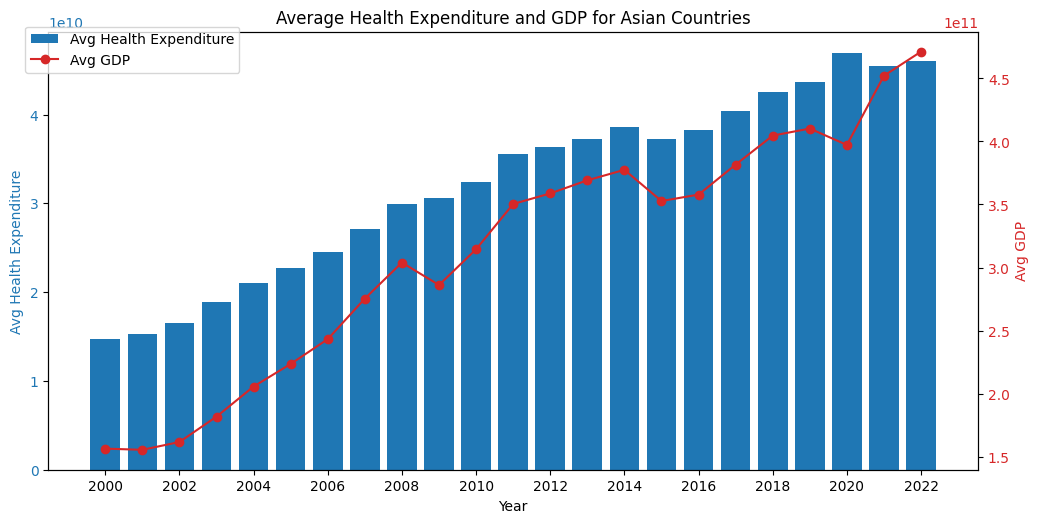

In [ ]:
pandas_df.sort_values(by='Year', inplace=True)

pandas_df['Year'] = pd.to_numeric(pandas_df['Year'])

fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase the size of the plot

# Bar chart for Education Expenditure
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Health Expenditure', color=color)
ax1.bar(pandas_df['Year'], pandas_df['avg_Health_Expenditure'], color=color, label='Avg Health Expenditure')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for GDP (line chart)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg GDP', color=color)
ax2.plot(pandas_df['Year'], pandas_df['avg_GDP'], color=color, label='Avg GDP', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Adjusting x-axis labels
plt.xticks(pandas_df['Year'][::2], rotation=45)  # Display each year and rotate labels to 45 degrees
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin

# Displaying the legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Displaying the plot
plt.title('Average Health Expenditure and GDP for Asian Countries')
plt.show()

In [ ]:
grouped_df = countries_df.groupBy("Year").agg(avg(col("GDP")).alias("avg_GDP"), avg(col("Education Expenditure")).alias("avg_Education_Expenditure"))

# Collect data to the driver as a Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()
pandas_df.head(20)
pandas_df.sort_values('Year', ascending=True)

,Year,avg_GDP,avg_Education_Expenditure
16,2000,1.562842e+11,2.090315e+10
14,2001,1.553418e+11,2.102164e+10
21,2002,1.615394e+11,2.196853e+10
0,2003,1.816729e+11,2.473908e+10
9,2004,2.055501e+11,2.763094e+10
15,2005,2.234883e+11,3.008119e+10
4,2006,2.431437e+11,3.263149e+10
1,2007,2.753076e+11,3.666634e+10
19,2008,3.039445e+11,4.157345e+10
12,2009,2.861176e+11,3.902190e+10


In [ ]:
pandas_df.dropna()

,Year,avg_GDP,avg_Education_Expenditure
0,2003,1.816729e+11,2.473908e+10
1,2007,2.753076e+11,3.666634e+10
2,2018,4.046730e+11,5.507403e+10
3,2015,3.527546e+11,4.899136e+10
4,2006,2.431437e+11,3.263149e+10
5,2022,4.712978e+11,6.571357e+10
6,2013,3.691925e+11,5.340624e+10
7,2014,3.775064e+11,5.462182e+10
8,2019,4.102624e+11,5.583105e+10
9,2004,2.055501e+11,2.763094e+10


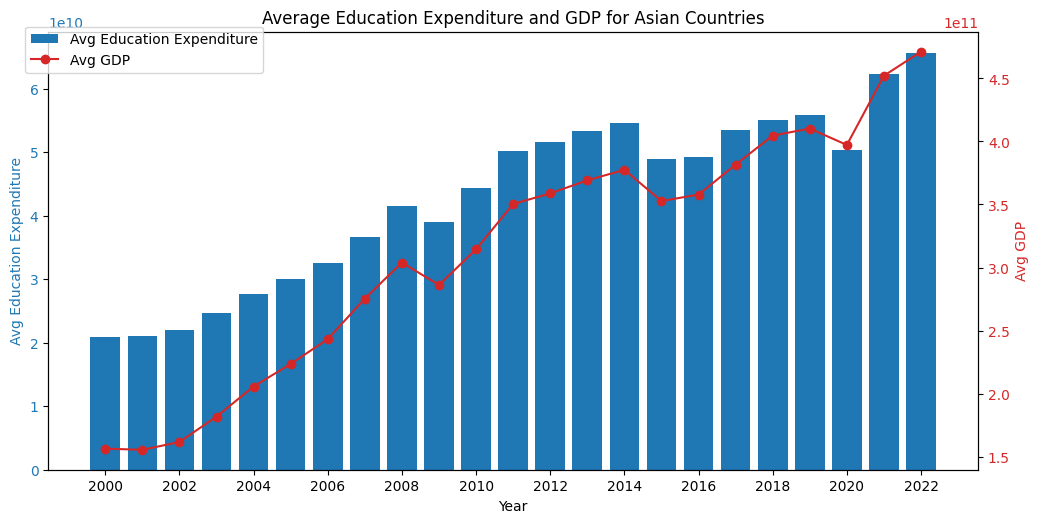

In [ ]:
pandas_df.sort_values(by='Year', inplace=True)

pandas_df['Year'] = pd.to_numeric(pandas_df['Year'])

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase the size of the plot

# Bar chart for Education Expenditure
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Education Expenditure', color=color)
ax1.bar(pandas_df['Year'], pandas_df['avg_Education_Expenditure'], color=color, label='Avg Education Expenditure')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for GDP (line chart)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg GDP', color=color)
ax2.plot(pandas_df['Year'], pandas_df['avg_GDP'], color=color, label='Avg GDP', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Adjusting x-axis labels
plt.xticks(pandas_df['Year'][::2], rotation=45)  # Display each year and rotate labels to 45 degrees
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Average Education Expenditure and GDP for Asian Countries')
plt.show()


#Industry Expenditure and R&D Analysis

In [ ]:
# Filter for the "Asia" continent
filtered_data = countries_df.filter(col("Continent Name") == "North America")

grouped_df = filtered_data.groupBy("Year").agg(avg(col("GDP")).alias("avg_GDP"), avg(col("Industry (% GDP)")).alias("avg_Industry_Expenditure"))

# Collecting data to the driver as a Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()
pandas_df.head(20)

,Year,avg_GDP,avg_Industry_Expenditure
0,2003,4.047615e+11,21.073812
1,2007,5.271088e+11,21.812519
2,2018,7.317107e+11,20.295621
3,2015,6.525270e+11,19.674803
4,2006,4.991573e+11,22.131667
5,2022,9.015467e+11,20.744887
6,2013,6.216352e+11,20.087766
7,2014,6.437840e+11,19.979717
8,2019,7.600182e+11,20.082739
9,2004,4.340184e+11,21.222903


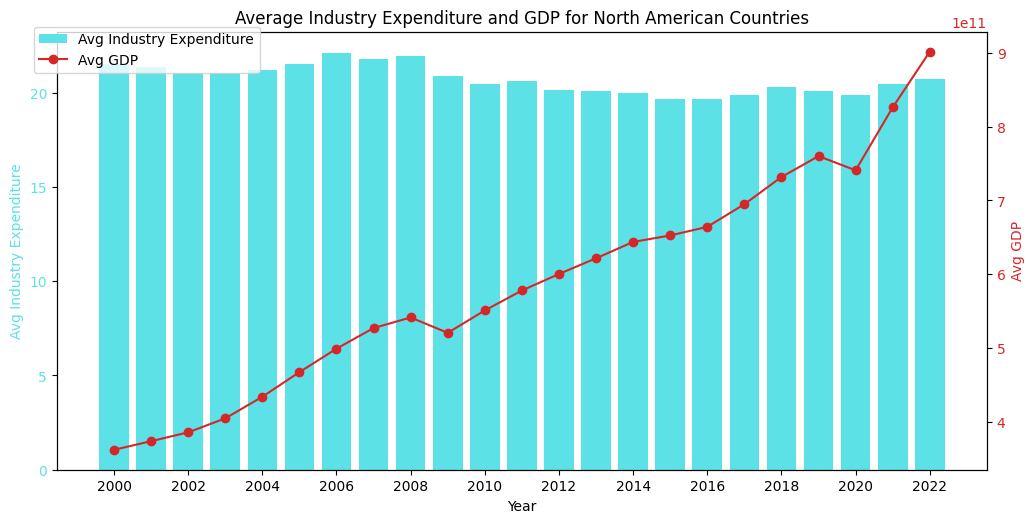

In [ ]:


# Sort DataFrame by 'Year'
pandas_df.sort_values(by='Year', inplace=True)

pandas_df['Year'] = pd.to_numeric(pandas_df['Year'])

fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase the size of the plot

# Bar chart for Education Expenditure
color = '#5ce1e6'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Industry Expenditure', color=color)
ax1.bar(pandas_df['Year'], pandas_df['avg_Industry_Expenditure'], color=color, label='Avg Industry Expenditure')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for GDP (line chart)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg GDP', color=color)
ax2.plot(pandas_df['Year'], pandas_df['avg_GDP'], color=color, label='Avg GDP', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Adjusting x-axis labels
plt.xticks(pandas_df['Year'][::2], rotation=45)  # Display each year and rotate labels to 45 degrees
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


plt.title('Average Industry Expenditure and GDP for North American Countries')
plt.show()

In [ ]:
filtered_data = countries_df.filter(col("Continent Name") == "North America")

grouped_df = filtered_data.groupBy("Year").agg(avg(col("GDP")).alias("avg_GDP"), avg(col("R&D")).alias("avg_R&D_Expenditure"))

# Collecting data to the driver as a Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()
pandas_df.head(20)

,Year,avg_GDP,avg_R&D_Expenditure
0,2003,4.047615e+11,1.852993e+10
1,2007,5.271088e+11,2.434826e+10
2,2018,7.317107e+11,3.825777e+10
3,2015,6.525270e+11,3.171459e+10
4,2006,4.991573e+11,2.255385e+10
5,2022,9.015467e+11,4.403178e+10
6,2013,6.216352e+11,2.910856e+10
7,2014,6.437840e+11,3.032861e+10
8,2019,7.600182e+11,4.175914e+10
9,2004,4.340184e+11,1.941373e+10


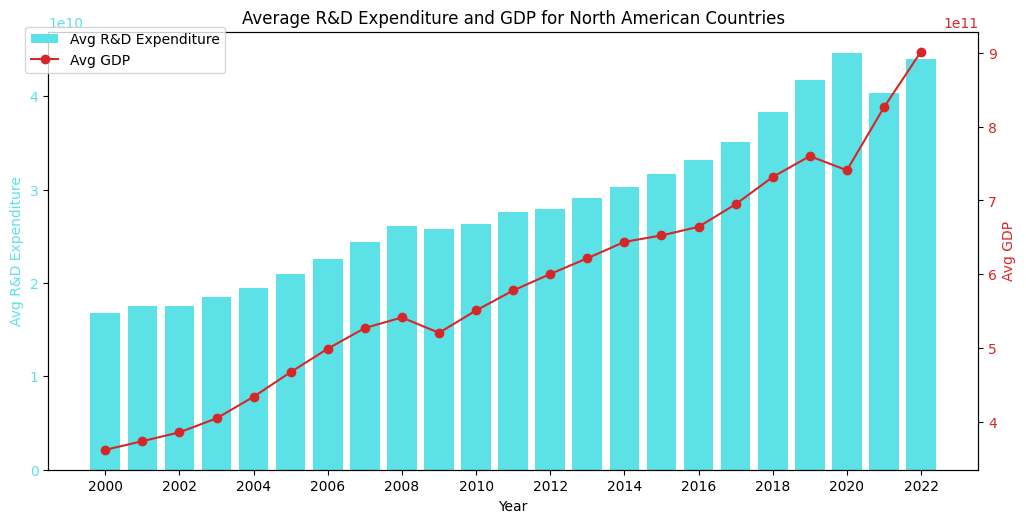

In [ ]:
pandas_df.sort_values(by='Year', inplace=True)

pandas_df['Year'] = pd.to_numeric(pandas_df['Year'])

fig, ax1 = plt.subplots(figsize=(12, 6))  # Increase the size of the plot

# Bar chart for Education Expenditure
color = '#5ce1e6'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg R&D Expenditure', color=color)
ax1.bar(pandas_df['Year'], pandas_df['avg_R&D_Expenditure'], color=color, label='Avg R&D Expenditure')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for GDP (line chart)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg GDP', color=color)
ax2.plot(pandas_df['Year'], pandas_df['avg_GDP'], color=color, label='Avg GDP', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Adjusting x-axis labels
plt.xticks(pandas_df['Year'][::2], rotation=45)  # Display each year and rotate labels to 45 degrees
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Average R&D Expenditure and GDP for North American Countries')
plt.show()

# Net Trade Surplus Vs Deficit



In [ ]:

columns_to_avg = ["Export", "Import", "Agriculture Contribution($)", "FDI net inflows", "Tax revenue", "FDI net outflows","Net Trade","GDP"]
agg_exprs = [F.avg(col_name).alias(f"Avg_{col_name.replace(' ', '_')}") for col_name in columns_to_avg]
avg_trade = countries_df_with_mean.groupBy("Country Name").agg(*agg_exprs)



In [ ]:
avgtrade= countries_df_with_mean.groupBy("Country Name").agg(F.avg("Net Trade").alias("AvgNet Trade"))

vdf = avgtrade.withColumn("TradeStatus", col("AvgNet Trade") >= 0)

#Categorize the top 10 countries based on surplus and deficit
top_10_countries_surplus = vdf.orderBy("AvgNet Trade", ascending=False).limit(10)
top_10_countries_deficit = vdf.orderBy("AvgNet Trade").limit(10)

print("Top 10 Countries with Trade Surplus:")
top_10_countries_surplus.select("Country Name", "AvgNet Trade").show()

print("Top 10 Countries with Trade Deficit:")
top_10_countries_deficit.select("Country Name", "AvgNet Trade").show()

Top 10 Countries with Trade Surplus:
+--------------------+--------------------+
|        Country Name|        AvgNet Trade|
+--------------------+--------------------+
|               China|2.143607235948495E11|
|             Germany|1.790936174957198E11|
|  Russian Federation|1.135029732101060...|
|        Saudi Arabia| 8.13732720966033E10|
|         Netherlands|7.060216149322157E10|
|           Singapore| 6.92474432563522E10|
|United Arab Emirates|6.612491609280403E10|
|             Ireland|5.404842804059573E10|
|         Switzerland|5.203255201400036E10|
|              Norway|4.651232477806148E10|
+--------------------+--------------------+

Top 10 Countries with Trade Deficit:
+--------------------+--------------------+
|        Country Name|        AvgNet Trade|
+--------------------+--------------------+
|       United States|-5.91882081189879...|
|               India|-5.62615080361661...|
|      United Kingdom|-4.44131768559667...|
|St. Vincent and t...|-2.36578144703631...|
|

In [ ]:
# Converting PySpark DataFrame to Pandas DataFrame
top_10_surplus_pd = top_10_countries_surplus.toPandas()
top_10_deficit_pd = top_10_countries_deficit.toPandas()

# A bar chart for Trade Surplus
fig_surplus = px.bar(
    top_10_surplus_pd,
    x="Country Name",
    y="AvgNet Trade",
    title="Top 10 Countries with Trade Surplus",
    labels={"NetTrade": "Net Trade (Surplus)"},
    color="AvgNet Trade",
)
fig_surplus.show()

In [ ]:
# A bar chart for Trade Deficit
fig_deficit = px.bar(
    top_10_deficit_pd,
    x="Country Name",
    y="AvgNet Trade",
    title="Top 10 Countries with Trade Deficit",
    labels={"NetTrade": "Net Trade (Deficit)"},
    color="AvgNet Trade",
)

fig_deficit.show()


In [ ]:
##Categorize the continents based on surplus and deficit
avgtrade2= countries_df_with_mean.groupBy("Continent Name").agg(F.avg("Net Trade").alias("AvgNet Trade"))
vdf2 = avgtrade2.withColumn("TradeStatus", col("AvgNet Trade") >= 0)
top_10_surplus = vdf2.orderBy("AvgNet Trade", ascending=False).limit(10)

print("Continents with Trade Surplus:")
top_10_surplus.select("Continent Name", "AvgNet Trade").show()

Continents with Trade Surplus:
+--------------+--------------------+
|Continent Name|        AvgNet Trade|
+--------------+--------------------+
|          Asia|1.335279616732740...|
|        Europe|1.065911480986088...|
| South America|1.0571612743643414E9|
|       Oceania|   5805874.402634154|
|        Africa|-4.15125459342942...|
| North America|-2.36578144703631...|
+--------------+--------------------+



In [ ]:
top_10_pd = top_10_surplus.toPandas()


# A bar chart for trade surplus and deficit for Continents
fig_surplus_world = px.bar(
    top_10_pd,
    x="Continent Name",
    y="AvgNet Trade",
    title="Continents with Trade Surplus & Deficit",
    labels={"NetTrade": "Net Trade (Surplus) and (Deficit)"},
    color="AvgNet Trade",
)

fig_surplus_world.show()

# Economic Indicator Analysis

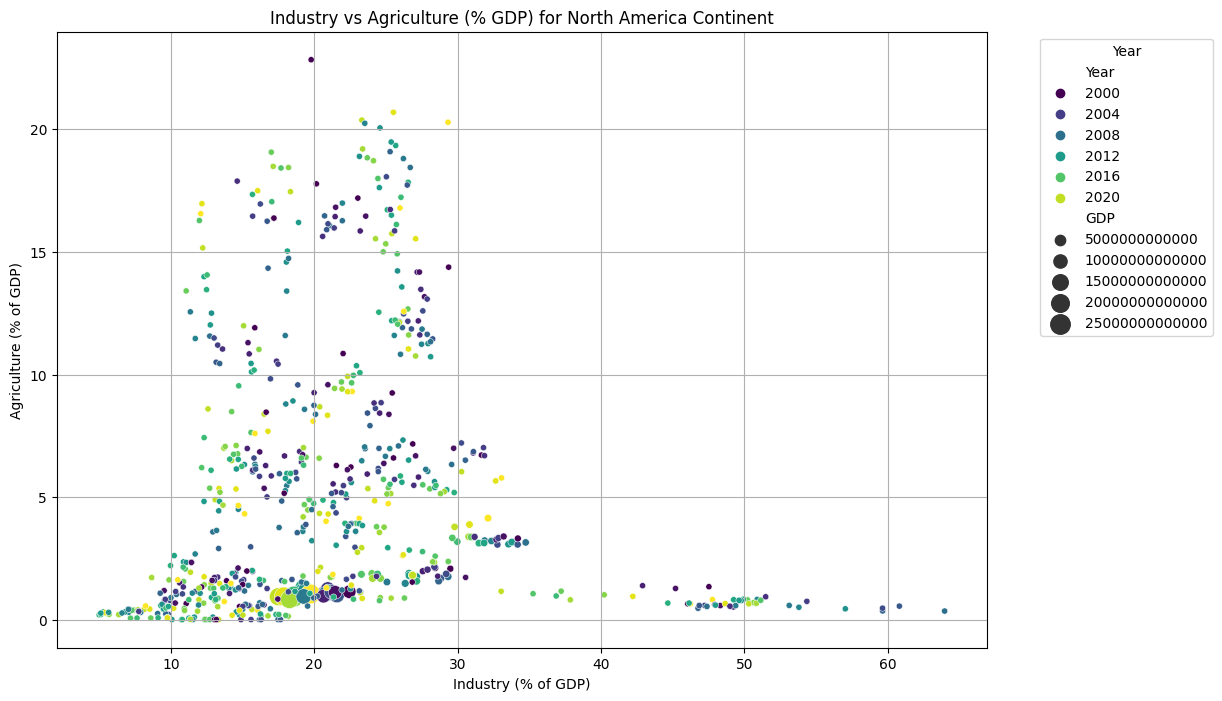

In [ ]:
# Preparing data for the plot
# Using 'Industry (% GDP)' and 'Agriculture (% GDP)' against 'Year'

#Considering only North America Countries for the scatterplot

filtered_data = countries_df[(countries_df['Continent Name']) == 'North America']

#Changing the filtereddata to Pandas Dataframe

filtered_data=filtered_data.toPandas()
# Creating the plot
plt.figure(figsize=(12, 8))

# Using seaborn's scatterplot
sns. scatterplot(data=filtered_data, x='Industry (% GDP)', y='Agriculture (% GDP)', hue= 'Year', palette='viridis', size='GDP', sizes=(20, 200))

plt.title('Industry vs Agriculture (% GDP) for North America Continent')
plt.xlabel('Industry (% of GDP)')
plt.ylabel('Agriculture (% of GDP)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()


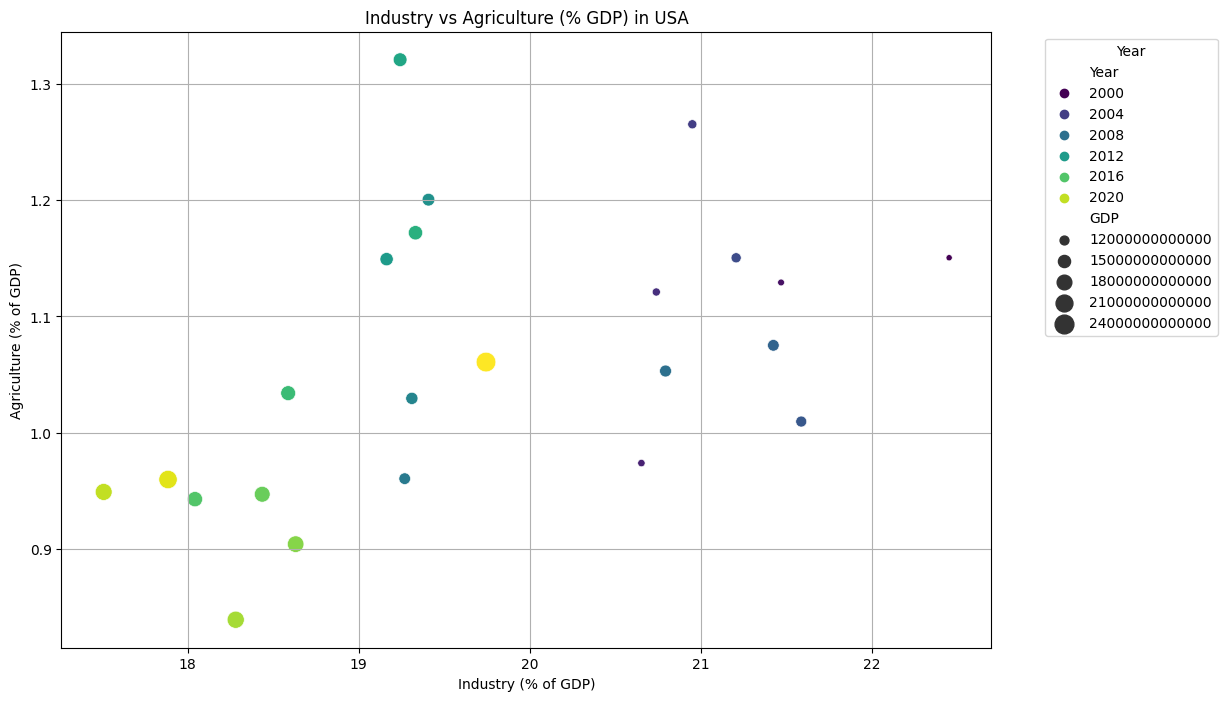

In [ ]:
# Preparing data for the plot
# Using 'Industry (% GDP)' and 'Agriculture (% GDP)' against 'Year'

#Considering only United States of America Countries for the scatterplot

filtered_data = countries_df[(countries_df['Country Name'])=='United States']
filtered_data=filtered_data.toPandas()

# Creating the plot
plt.figure(figsize=(12, 8))

# Using seaborn's scatterplot
sns. scatterplot(data=filtered_data, x='Industry (% GDP)', y='Agriculture (% GDP)', hue= 'Year', palette='viridis', size='GDP', sizes=(20, 200))

plt.title('Industry vs Agriculture (% GDP) in USA')
plt.xlabel('Industry (% of GDP)')
plt.ylabel('Agriculture (% of GDP)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()


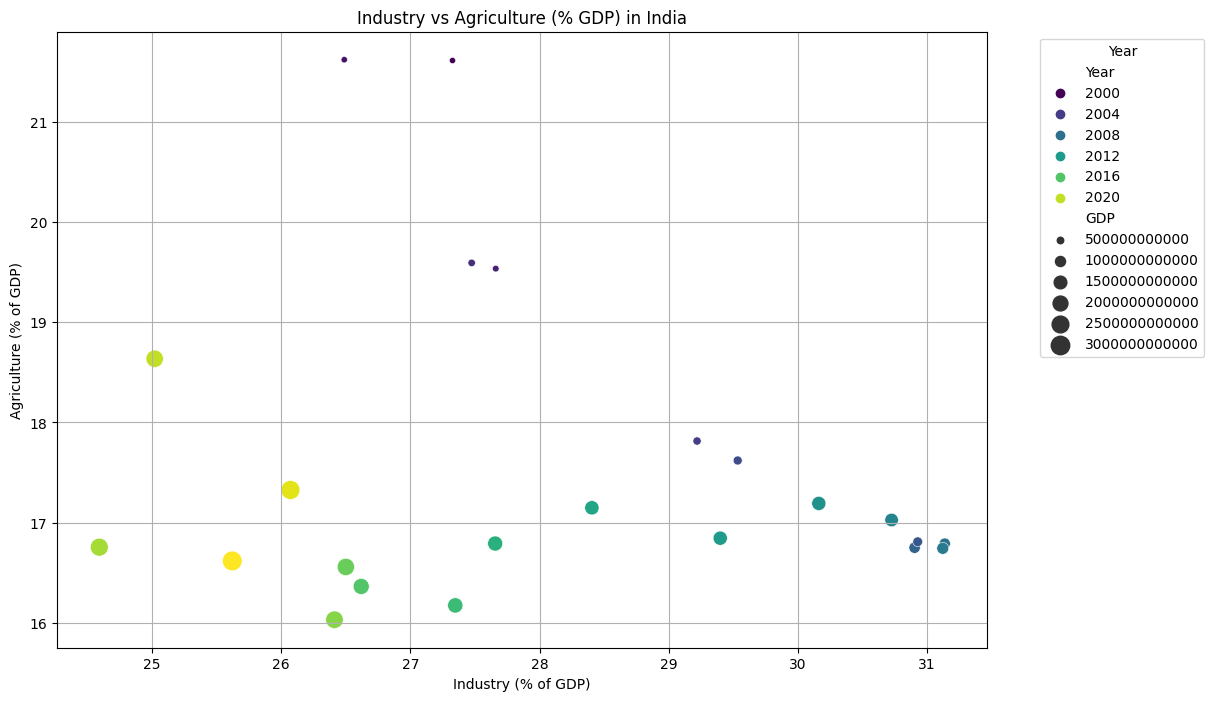

In [ ]:
filtered_data = countries_df[(countries_df['Country Name'])=='India']
filtered_data=filtered_data.toPandas()

# Creating the plot
plt.figure(figsize=(12, 8))

# Using seaborn's scatterplot
sns. scatterplot(data=filtered_data, x='Industry (% GDP)', y='Agriculture (% GDP)', hue= 'Year', palette='viridis', size='GDP', sizes=(20, 200))

plt.title('Industry vs Agriculture (% GDP) in India')
plt.xlabel('Industry (% of GDP)')
plt.ylabel('Agriculture (% of GDP)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()


#Clustering


#Net Trade

In [ ]:
df = countries_df.filter(col("Continent Name") == "Asia")

# Group by 'Category' and calculate mean of 'Value'
grouped_df = df.groupBy("Country Name").agg(F.mean("Net Trade").alias("MeanValue"))

grouped_df.show()

+------------------+--------------------+
|      Country Name|           MeanValue|
+------------------+--------------------+
|       Philippines|-1.46278846241492...|
|          Malaysia|2.907767965422694...|
|         Singapore| 6.92474432563522E10|
|              Iraq|1.305444485612761...|
|          Cambodia|-6.436849530191209E8|
|       Afghanistan|                NULL|
|            Jordan|-6.722033562285281E9|
|          Maldives|  -8.9263509826695E7|
|         Sri Lanka|-4.161342561244564E9|
|  Macao SAR, China|1.223236740102315...|
|Iran, Islamic Rep.| 8.053461495584796E9|
|             Qatar|3.399180754961549...|
|           Myanmar|-6.106555737225648E8|
| Brunei Darussalam| 3.451905959984656E9|
|             China|2.143607235948495E11|
|             India|-5.62615080361661...|
|            Kuwait|3.194049857743361E10|
|       Timor-Leste|-7.731703827047646E8|
|           Lao PDR|-1.39215429252548...|
|        Tajikistan|-1.83592398584328...|
+------------------+--------------

In [ ]:
df = countries_df.filter(col("Continent Name") == "Asia")

# Group by 'Category' and calculate mean of 'Value'
grouped_df = df.groupBy("Country Name").agg(F.mean("Net Trade").alias("NetTrade_MeanValue"))

grouped_df = grouped_df.na.fill(0)

# Converting country names into numerical features
indexer = StringIndexer(inputCol="Country Name", outputCol="countryIndex")
encoder = OneHotEncoder(inputCols=["countryIndex"], outputCols=["countryVec"])

# Combining all features into one vector
vec_assembler = VectorAssembler(inputCols=["countryVec", "NetTrade_MeanValue"], outputCol="features")

# Creating a K-means model
kmeans = KMeans().setK(3).setSeed(1)
pipeline = Pipeline(stages=[indexer, encoder, vec_assembler, kmeans])
model = pipeline.fit(grouped_df)
predictions = model.transform(grouped_df)

# Convert to Pandas DataFrame for plotting
pandas_df = predictions.toPandas()
predictions.show()

+------------------+--------------------+------------+---------------+--------------------+----------+
|      Country Name|  NetTrade_MeanValue|countryIndex|     countryVec|            features|prediction|
+------------------+--------------------+------------+---------------+--------------------+----------+
|       Philippines|-1.46278846241492...|        34.0|(49,[34],[1.0])|(50,[34,49],[1.0,...|         0|
|          Malaysia|2.907767965422694...|        27.0|(49,[27],[1.0])|(50,[27,49],[1.0,...|         0|
|         Singapore| 6.92474432563522E10|        38.0|(49,[38],[1.0])|(50,[38,49],[1.0,...|         2|
|              Iraq|1.305444485612761...|        15.0|(49,[15],[1.0])|(50,[15,49],[1.0,...|         0|
|          Cambodia|-6.436849530191209E8|         7.0| (49,[7],[1.0])|(50,[7,49],[1.0,-...|         0|
|       Afghanistan|                 0.0|         0.0| (49,[0],[1.0])|      (50,[0],[1.0])|         0|
|            Jordan|-6.722033562285281E9|        18.0|(49,[18],[1.0])|(50

In [ ]:
df_selected = predictions.select("Country Name", "NetTrade_MeanValue","prediction")

# Show the resulting DataFrame
df_selected.show()

+------------------+--------------------+----------+
|      Country Name|  NetTrade_MeanValue|prediction|
+------------------+--------------------+----------+
|       Philippines|-1.46278846241492...|         0|
|          Malaysia|2.907767965422694...|         0|
|         Singapore| 6.92474432563522E10|         2|
|              Iraq|1.305444485612761...|         0|
|          Cambodia|-6.436849530191209E8|         0|
|       Afghanistan|                 0.0|         0|
|            Jordan|-6.722033562285281E9|         0|
|          Maldives|  -8.9263509826695E7|         0|
|         Sri Lanka|-4.161342561244564E9|         0|
|  Macao SAR, China|1.223236740102315...|         0|
|Iran, Islamic Rep.| 8.053461495584796E9|         0|
|             Qatar|3.399180754961549...|         0|
|           Myanmar|-6.106555737225648E8|         0|
| Brunei Darussalam| 3.451905959984656E9|         0|
|             China|2.143607235948495E11|         1|
|             India|-5.62615080361661...|     

In [ ]:
unique_value_counts = predictions.groupBy("prediction").agg(count("prediction").alias("count"))

# Showing the count of unique values in the prediction column
unique_value_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    1|
|         2|    4|
|         0|   45|
+----------+-----+



In [ ]:
category_0_df = df_selected.filter(df_selected['prediction'] == 0).limit(6)

# Filtering for all values of category 0 and 2
category_1_and_2_df = df_selected.filter(df_selected['prediction'].isin([1, 2]))

df_result= category_1_and_2_df.union(category_0_df)

df_result.show()

+--------------------+--------------------+----------+
|        Country Name|  NetTrade_MeanValue|prediction|
+--------------------+--------------------+----------+
|           Singapore| 6.92474432563522E10|         2|
|               China|2.143607235948495E11|         1|
|  Russian Federation|1.135029732101060...|         2|
|        Saudi Arabia| 8.13732720966033E10|         2|
|United Arab Emirates|6.612491609280403E10|         2|
|         Philippines|-1.46278846241492...|         0|
|            Malaysia|2.907767965422694...|         0|
|                Iraq|1.305444485612761...|         0|
|            Cambodia|-6.436849530191209E8|         0|
|         Afghanistan|                 0.0|         0|
|              Jordan|-6.722033562285281E9|         0|
+--------------------+--------------------+----------+



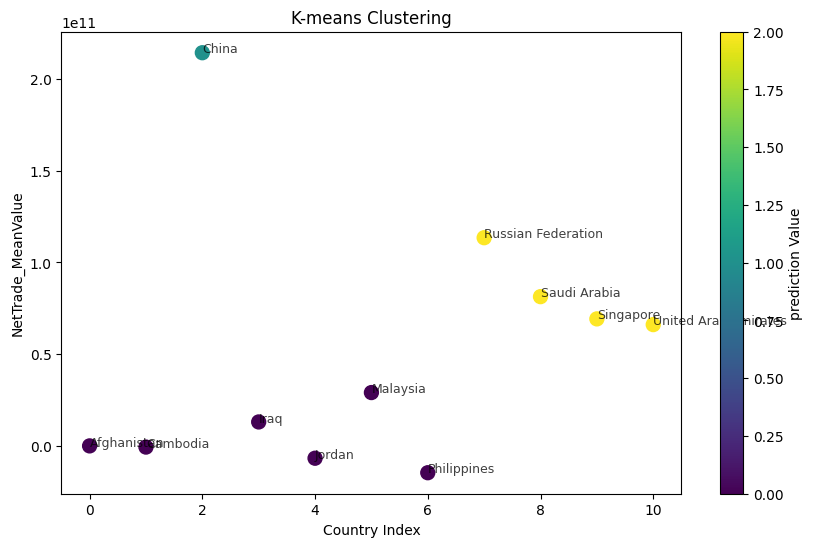

In [ ]:
local_data = df_result.select("Country Name", "NetTrade_MeanValue", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))

local_data['Country Index'] = local_data['Country Name'].astype('category').cat.codes

# Scatter plot
plt.scatter(local_data['Country Index'], local_data['NetTrade_MeanValue'], c=local_data['prediction'], s=100)

for index, row in local_data.iterrows():
    plt.annotate(row['Country Name'], (row['Country Index'], row['NetTrade_MeanValue']), fontsize=9, alpha=0.75)

# Adding labels and title
plt.xlabel('Country Index')
plt.ylabel('NetTrade_MeanValue')
plt.title('K-means Clustering')
plt.colorbar(label='prediction Value')

# Show plot
plt.show()



In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.89328130769151


In [ ]:
#A Silhouette Score of approximately 0.89 is quite high,
#indicating that K-means clustering model has performed very well in segmenting the data into clusters.
#In the context of Silhouette Scores, values close to 1 suggest that the clusters are well separated and
#the data points within each cluster are close to each other.
#This implies that the model has effectively distinguished between different clusters.

#GDP Clustering


In [ ]:
df = countries_df.filter(col("Continent Name") == "Asia")

# Group by 'Category' and calculate mean of 'Value'
grouped_df = df.groupBy("Country Name").agg(F.mean("GDP").alias("MeanValue"))

grouped_df = grouped_df.na.fill(0)

# Convert country names into numerical features
indexer = StringIndexer(inputCol="Country Name", outputCol="countryIndex")
encoder = OneHotEncoder(inputCols=["countryIndex"], outputCols=["countryVec"])

# Combining all features into one vector
vec_assembler = VectorAssembler(inputCols=["countryVec", "MeanValue"], outputCol="features")

# Creating a K-means model
kmeans = KMeans().setK(3).setSeed(1)
pipeline = Pipeline(stages=[indexer, encoder, vec_assembler, kmeans])
model = pipeline.fit(grouped_df)
GDP_predictions = model.transform(grouped_df)

# Converting to Pandas DataFrame for plotting
pandas_df = GDP_predictions.toPandas()

GDP_predictions.show()

+------------------+--------------------+------------+---------------+--------------------+----------+
|      Country Name|           MeanValue|countryIndex|     countryVec|            features|prediction|
+------------------+--------------------+------------+---------------+--------------------+----------+
|       Philippines|2.304707154974852...|        34.0|(49,[34],[1.0])|(50,[34,49],[1.0,...|         1|
|          Malaysia|2.498384071082232E11|        27.0|(49,[27],[1.0])|(50,[27,49],[1.0,...|         1|
|         Singapore|2.493876753005495E11|        38.0|(49,[38],[1.0])|(50,[38,49],[1.0,...|         1|
|              Iraq|1.418669826231467...|        15.0|(49,[15],[1.0])|(50,[15,49],[1.0,...|         1|
|          Cambodia|1.433179658323554E10|         7.0| (49,[7],[1.0])|(50,[7,49],[1.0,1...|         1|
|       Afghanistan|1.415197048074285...|         0.0| (49,[0],[1.0])|(50,[0,49],[1.0,1...|         1|
|            Jordan|2.801233400747707...|        18.0|(49,[18],[1.0])|(50

In [ ]:
#Selecting only the specific columns
df_selected = GDP_predictions.select("Country Name", "MeanValue","prediction")

df_selected.show()


+------------------+--------------------+----------+
|      Country Name|           MeanValue|prediction|
+------------------+--------------------+----------+
|       Philippines|2.304707154974852...|         1|
|          Malaysia|2.498384071082232E11|         1|
|         Singapore|2.493876753005495E11|         1|
|              Iraq|1.418669826231467...|         1|
|          Cambodia|1.433179658323554E10|         1|
|       Afghanistan|1.415197048074285...|         1|
|            Jordan|2.801233400747707...|         1|
|          Maldives| 2.983918002864009E9|         1|
|         Sri Lanka|5.698791425993897E10|         1|
|  Macao SAR, China|2.918755767186322...|         1|
|Iran, Islamic Rep.|3.496482947221207E11|         1|
|             Qatar|1.212377368347158...|         1|
|           Myanmar|4.021544956036207E10|         1|
| Brunei Darussalam|1.230056532759099E10|         1|
|             China|7.886521673340515E12|         2|
|             India|1.709622746260717...|     

In [ ]:
unique_value_counts = GDP_predictions.groupBy("prediction").agg(count("prediction").alias("count"))

# Showing the count of unique values in the prediction column
unique_value_counts.show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|   42|
|         2|    2|
|         0|    6|
+----------+-----+



In [ ]:
# Filtering for 6 values of category 1
category_1_df = df_selected.filter(df_selected['prediction'] == 1).limit(6)

# Filtering for all values of category 0 and 2
category_0_and_2_df = df_selected.filter(df_selected['prediction'].isin([0, 2]))

df_result= category_0_and_2_df.union(category_1_df)

df_result.show()


+------------------+--------------------+----------+
|      Country Name|           MeanValue|prediction|
+------------------+--------------------+----------+
|             China|7.886521673340515E12|         2|
|             India|1.709622746260717...|         0|
|Russian Federation|1.353758215020322...|         0|
|         Indonesia|6.977763841375312E11|         0|
|       Korea, Rep.|1.218103824351776...|         0|
|      Saudi Arabia|5.661662241143308E11|         0|
|           Turkiye|6.771286462705875E11|         0|
|             Japan|4.980232096069499E12|         2|
|       Philippines|2.304707154974852...|         1|
|          Malaysia|2.498384071082232E11|         1|
|         Singapore|2.493876753005495E11|         1|
|              Iraq|1.418669826231467...|         1|
|          Cambodia|1.433179658323554E10|         1|
|       Afghanistan|1.415197048074285...|         1|
+------------------+--------------------+----------+



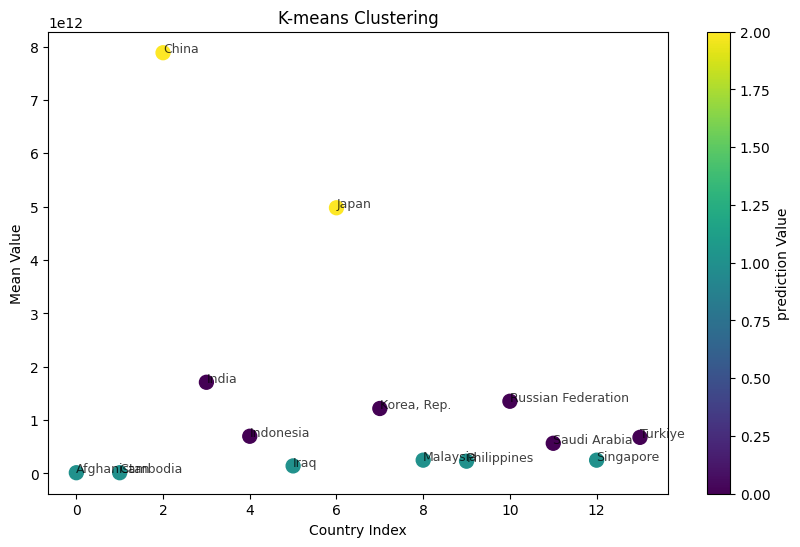

In [ ]:
local_data = df_result.select("Country Name", "MeanValue", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))

local_data['Country Index'] = local_data['Country Name'].astype('category').cat.codes

# Scatter plot
plt.scatter(local_data['Country Index'], local_data['MeanValue'], c=local_data['prediction'], s=100)

for index, row in local_data.iterrows():
    plt.annotate(row['Country Name'], (row['Country Index'], row['MeanValue']), fontsize=9, alpha=0.75)

# Adding labels and title
plt.xlabel('Country Index')
plt.ylabel('Mean Value')
plt.title('K-means Clustering')
plt.colorbar(label='prediction Value')

# Show plot
plt.show()



In [ ]:
predictionAndLabels = df_result.select(['prediction', 'MeanValue']).rdd.map(lambda x: (float(x[0]), float(x[1])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate accuracy
accuracy = metrics.accuracy
print(f"Accuracy = {accuracy}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Accuracy = 0.0


In [ ]:
#Silhouette prediction for GDP
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(GDP_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8822486313401376


A Silhouette Score of approximately 0.88 is quite high,
indicating that K-means clustering model has performed very well in segmenting the data into clusters.
In the context of Silhouette Scores, values close to 1 suggest that the clusters are well separated and
the data points within each cluster are close to each other.
This implies that the model has effectively distinguished between different clusters.

#Health and Education Expenditure GDP **Prediction**

In [ ]:
df = countries_df_with_mean.filter(col("Continent Name") == "Asia")

selected_df = df.select("GDP", "Health Expenditure", "Education Expenditure")

selected_df.show()

+-------------------+--------------------+---------------------+
|                GDP|  Health Expenditure|Education Expenditure|
+-------------------+--------------------+---------------------+
|2.00167478583122E10|1.2243213081811943E9|  3.025618440899166E9|
|5.10228634992258E11|1.300278414184306...| 6.977249193748027E10|
|5.22033446211625E11|3.727591878166492...| 7.392505758823116E10|
|2.02257458160849E11| 6.595730795118979E9| 3.734609155357768E10|
|1.79677131707294E11| 4.779006463889195E9| 1.605743903147515...|
|2.01753110088579E11| 9.861388039718773E9| 1.207020224629654...|
|5.10169108562595E12|2.219023687796209E11| 6.892384773449083E11|
| 5.49425220790502E9|1.7174950812265804E8| 1.0524811611769252E9|
|3.06445871631969E11|1.194610249591526...| 5.008688056661716E10|
|3.07576360584992E11|1.133611588421365...| 8.870240637917133E10|
|2.79356526366334E11| 8.821860617909557E9| 8.062743169836334E10|
|2.52518218262806E11| 8.273626344279815E9| 4.661744477953405E10|
| 3.71952418070289E9| 2.0

In [ ]:
data = selected_df.na.drop()

data.printSchema()

# Selecting and renaming the columns
data = data.selectExpr("GDP as label", "`Health Expenditure` as health_expenditure", "`Education Expenditure` as education_expenditure")

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=["health_expenditure", "education_expenditure"], outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Creating the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")

lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Calculate MAE
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print("Mean Absolute Error (MAE) on test data =", mae)

# Calculate R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("R-squared on test data =", r2)


root
 |-- GDP: double (nullable = true)
 |-- Health Expenditure: double (nullable = true)
 |-- Education Expenditure: double (nullable = true)

Root Mean Squared Error (RMSE) on test data = 105745810039.08734
Mean Absolute Error (MAE) on test data = 62901474102.67041
R-squared on test data = 0.9877036298080142


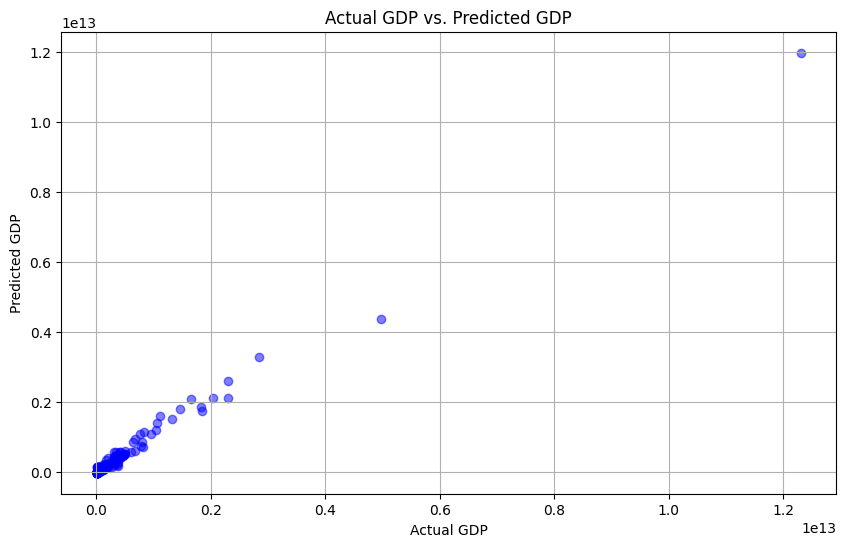

In [ ]:
# Assuming 'predictions' contains the actual GDP ('label') and predicted GDP ('prediction')
actual_gdp = predictions.select("label").rdd.map(lambda row: row[0]).collect()
predicted_gdp = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_gdp, predicted_gdp, c='blue', alpha=0.5)
plt.title("Actual GDP vs. Predicted GDP")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.grid(True)
plt.show()

In [ ]:
data = df.select("GDP", "Health Expenditure", "Education Expenditure")

# Assemble the features into a feature vector
feature_cols = ["Health Expenditure", "Education Expenditure"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Create the Decision Tree Regressor model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="GDP")

dt_model = dt.fit(train_data)

predictions_dt = dt_model.transform(test_data)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_dt)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Show the decision tree model
#print("Learned regression tree model:")
#print(dt_model.toDebugString)
# Calculate MAE
mae = evaluator.evaluate(predictions_dt, {evaluator.metricName: "mae"})
print("Mean Absolute Error (MAE) on test data =", mae)

# Calculate R-squared
r2 = evaluator.evaluate(predictions_dt, {evaluator.metricName: "r2"})
print("R-squared on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 391992838911.1298
Mean Absolute Error (MAE) on test data = 92886480863.04895
R-squared on test data = 0.8310310679433014


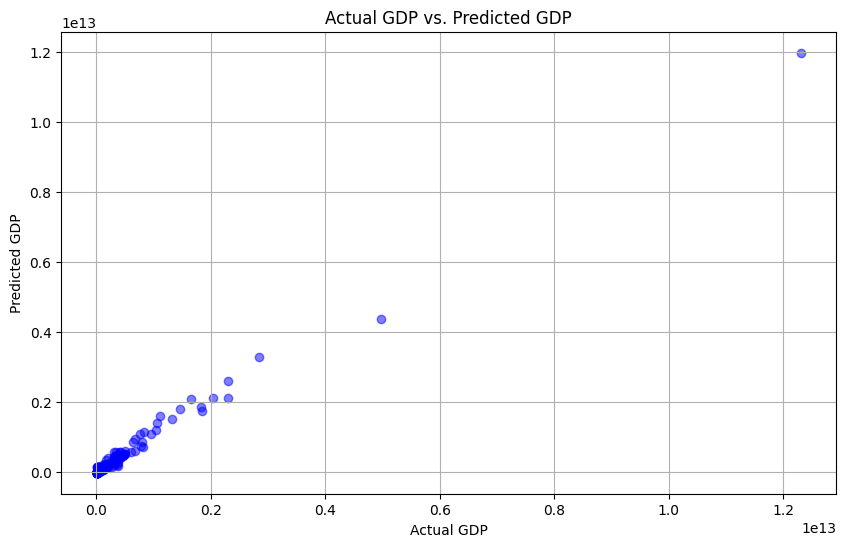

In [ ]:
# Assuming 'predictions' contains the actual GDP ('label') and predicted GDP ('prediction')
actual_gdp_dt = predictions_dt.select("GDP").rdd.map(lambda row: row[0]).collect()
predicted_gdp_dt = predictions_dt.select("prediction").rdd.map(lambda row: row[0]).collect()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_gdp, predicted_gdp, c='blue', alpha=0.5)
plt.title("Actual GDP vs. Predicted GDP")
plt.xlabel("Actual GDP")
plt.ylabel("Predicted GDP")
plt.grid(True)
plt.show()

#Time Series


In [ ]:
gdp_df = countries_df_with_mean.filter(countries_df['Country Name'] == "India").select("Year", "GDP")
# Sort the DataFrame by Year
gdp_df = gdp_df.sort("Year")

# Collecting the data to use with Matplotlib
data = gdp_df.collect()
years = [row['Year'] for row in data]
gdp_values = [row['GDP'] for row in data]

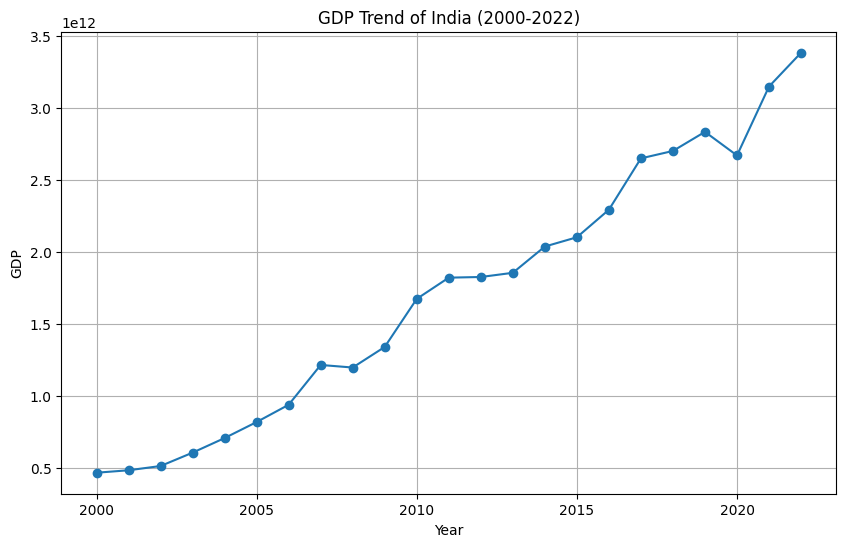

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP Trend of India (2000-2022)')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.grid(True)
plt.show()

In [ ]:
country_name = "India"  # Replace with the country you want to filter
gdp_india_df = countries_df_with_mean.filter(countries_df_with_mean['Country Name'] == country_name)

In [ ]:
columns = [
    "Agriculture Contribution($)", "Inflation Rate", "R&D", "Export",
    "Import", "Education Expenditure", "Health Expenditure", "Net Trade",
    "Total Unemployed", "Industry Contribution($)", "Service Contribution($)",
    "Miltary Expenditure", "FDI net inflows", "FDI net outflows", "Tax revenue",
    "Inflation consumer prices"
]


corr_df = gdp_india_df.select("GDP", *columns)

for column in columns:
    corr_value = corr_df.stat.corr("GDP", column)
    print(f"Correlation between GDP and {column}: {corr_value}")

Correlation between GDP and Agriculture Contribution($): 0.9956689171670497
Correlation between GDP and Inflation Rate: 0.07924113430402954
Correlation between GDP and R&D: 0.9908297631280558
Correlation between GDP and Export: 0.9762104415377986
Correlation between GDP and Import: 0.9570613550330147
Correlation between GDP and Education Expenditure: 0.983794249679181
Correlation between GDP and Health Expenditure: 0.9800112583508847
Correlation between GDP and Net Trade: -0.6895998195424575
Correlation between GDP and Total Unemployed: 0.5505897918819256
Correlation between GDP and Industry Contribution($): 0.9910958908994435
Correlation between GDP and Service Contribution($): 0.9991341219740344
Correlation between GDP and Miltary Expenditure: 0.9926028144176866
Correlation between GDP and FDI net inflows: 0.8774890290489686
Correlation between GDP and FDI net outflows: 0.5143415306790381
Correlation between GDP and Tax revenue: 0.3632708099945784
Correlation between GDP and Inflatio

<ipython-input-68-2acbe39b4212>:4: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



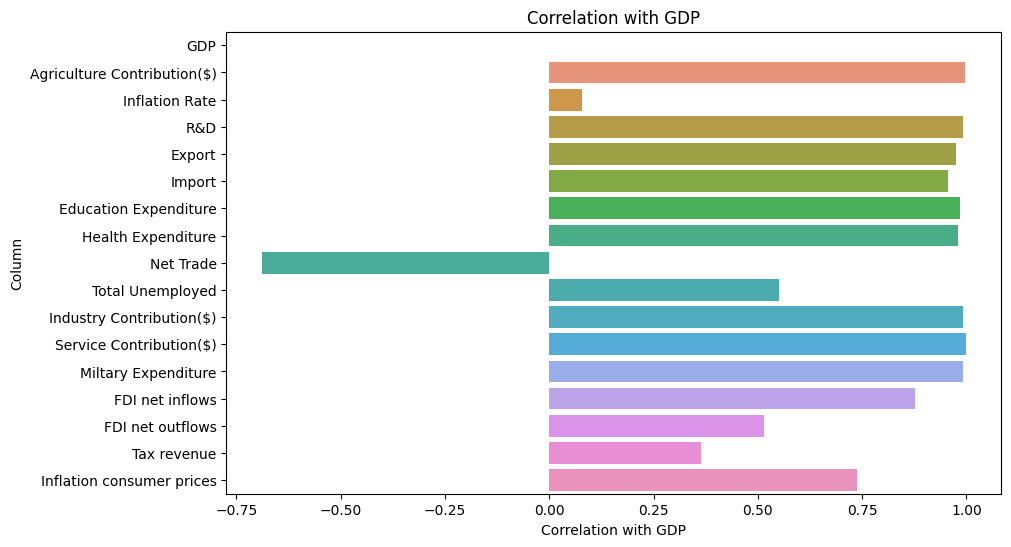

In [ ]:
columns = corr_df.columns

# Initialize an empty Series to store the correlation with GDP
corr_with_gdp = pd.Series(index=columns)

# Calculate correlations with GDP
for column in columns:
    if column != "GDP":  # Skipping correlation of GDP with itself
        corr_value = corr_df.stat.corr("GDP", column)
        corr_with_gdp[column] = corr_value

# Convert the Series to a DataFrame for plotting
corr_df_for_plotting = pd.DataFrame({'Column': corr_with_gdp.index, 'Correlation with GDP': corr_with_gdp.values})

# Plotting the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df_for_plotting, x='Correlation with GDP', y='Column')
plt.title('Correlation with GDP')
plt.show()

In [ ]:
high_corr_columns = corr_df_for_plotting[corr_df_for_plotting['Correlation with GDP'] >= 0.9]

In [ ]:
high_corr_columns

,Column,Correlation with GDP
1,Agriculture Contribution($),0.995669
3,R&D,0.990830
4,Export,0.976210
5,Import,0.957061
6,Education Expenditure,0.983794
7,Health Expenditure,0.980011
10,Industry Contribution($),0.991096
11,Service Contribution($),0.999134
12,Miltary Expenditure,0.992603


In [ ]:
# List of columns to be selected
selected_columns = high_corr_columns['Column'].tolist()

selected_columns = selected_columns + ['GDP',"Year"]
selected_columns

['Agriculture Contribution($)',
 'R&D',
 'Export',
 'Import',
 'Education Expenditure',
 'Health Expenditure',
 'Industry Contribution($)',
 'Service Contribution($)',
 'Miltary Expenditure',
 'GDP',
 'Year']

In [ ]:
# Selecting only the specified columns
gdp_india_df = gdp_india_df.select(selected_columns)

gdp_india_df.show()

+---------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+------------------------+-----------------------+--------------------+-------------------+----+
|Agriculture Contribution($)|                 R&D|              Export|              Import|Education Expenditure|  Health Expenditure|Industry Contribution($)|Service Contribution($)| Miltary Expenditure|                GDP|Year|
+---------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+------------------------+-----------------------+--------------------+-------------------+----+
|       2.246893547629659...|1.117980603410144...|2.737521248892097E11|3.471779679683150...| 1.501733751971239...| 4.67698796587272E10|    4.176139630846257E11|   6.170656320793173E11| 4.19928386621118E10|1.34188801698857E12|2009|
|       1.049469341232367...|3.5724089624062786E9|6.096352550447028E10|6.521

#GBR- Time Series


In [ ]:
# Data Splitting
train_df, test_df = gdp_india_df.randomSplit([0.7, 0.3], seed=42)

# Defining Pipeline Stages
feature_cols = [col for col in gdp_india_df.columns if col not in ['Year', 'GDP']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="GDP")


pipeline = Pipeline(stages=[assembler, scaler, gbt])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.48916e+11


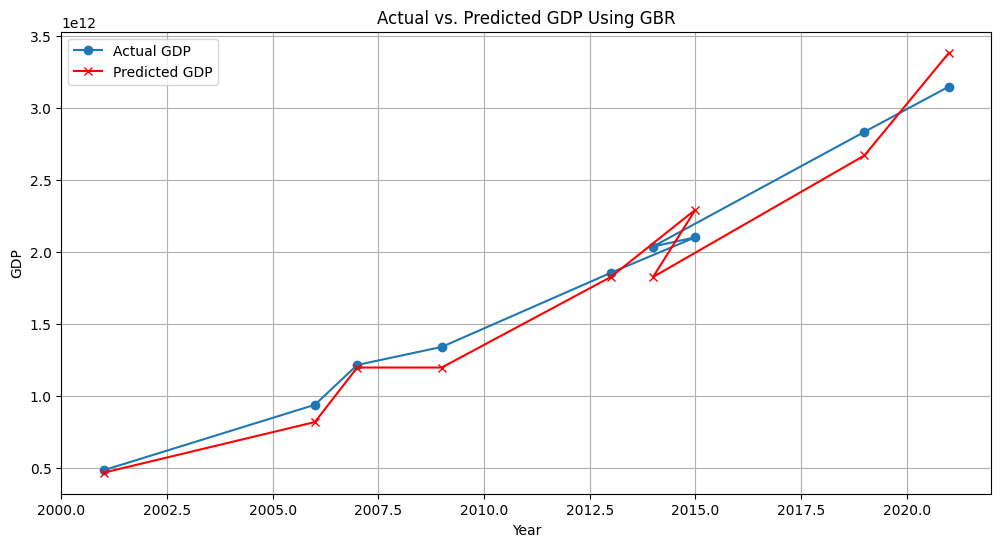

In [ ]:
# Convert PySpark DataFrames to Pandas DataFrames
test_df_pd = test_df.toPandas()
predictions_pd = predictions.toPandas()

# Extract the 'Year' and 'GDP' columns from the Pandas DataFrames
years = test_df_pd['Year'].tolist()
actual_gdp = test_df_pd['GDP'].tolist()
predicted_gdp = predictions_pd['prediction'].tolist()

# Plotting the original GDP and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(years, actual_gdp, label='Actual GDP', marker='o')
plt.plot(years, predicted_gdp, label='Predicted GDP', marker='x', color='red')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Actual vs. Predicted GDP Using GBR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Existing RMSE calculation
rmse_evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Calculating Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

# Calculating R-squared
r2_evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 1.48916e+11
Mean Absolute Error (MAE) on test data = 1.2537e+11
R-squared on test data = 0.967064


In [ ]:
#2023 GDP prediction

In [ ]:
# List of features to forecast
features = [
    'Agriculture Contribution($)', 'R&D', 'Export', 'Import',
    'Education Expenditure', 'Health Expenditure', 'Industry Contribution($)',
    'Service Contribution($)', 'Miltary Expenditure'
]

# Calculating YoY growth rate for each feature
for feature in features:
    window = Window.orderBy('Year')
    gdp_india_df = gdp_india_df.withColumn(f'{feature}_prev', lag(col(feature)).over(window))
    gdp_india_df = gdp_india_df.withColumn(f'{feature}_growth',
                                            (col(feature) - col(f'{feature}_prev')) / col(f'{feature}_prev'))

# Calculating the average growth rate
avg_growth_rates = {}
for feature in features:
    avg_growth = gdp_india_df.select(F.avg(f'{feature}_growth')).first()[0]
    avg_growth_rates[feature] = avg_growth
print(avg_growth_rates[feature])

# Estimate the values for 2023
estimates_2023 = {feature: gdp_india_df.where(col('Year') == 2022).select(feature).first()[0] * (1 + avg_growth_rates[feature])
                  for feature in features}

# Creating a DataFrame for the 2023 prediction
df_2023 = spark.createDataFrame([estimates_2023])
df_2023.show()

0.08797248271581065
+---------------------------+---------------------+--------------------+--------------------+--------------------+------------------------+-------------------+--------------------+-----------------------+
|Agriculture Contribution($)|Education Expenditure|              Export|  Health Expenditure|              Import|Industry Contribution($)|Miltary Expenditure|                 R&D|Service Contribution($)|
+---------------------------+---------------------+--------------------+--------------------+--------------------+------------------------+-------------------+--------------------+-----------------------+
|       6.100029369946395E11| 5.209367260313747E11|8.593729931673142E11|1.310444148627524...|1.040124822360358...|    9.499458907041786E11|8.93183170502045E10|2.776828129160319E10|   1.814683037009367...|
+---------------------------+---------------------+--------------------+--------------------+--------------------+------------------------+-------------------+-

In [ ]:
df_2023_transformed = model.transform(df_2023)

# Make the prediction
prediction_2023 = df_2023_transformed.select('prediction').collect()[0]['prediction']

print(f"Predicted GDP for 2023: {prediction_2023}")

Predicted GDP for 2023: 3385089881935.389


#Autoregressor - Time series



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Mean Squared Error (MSE): 3.3727614053010752e+22


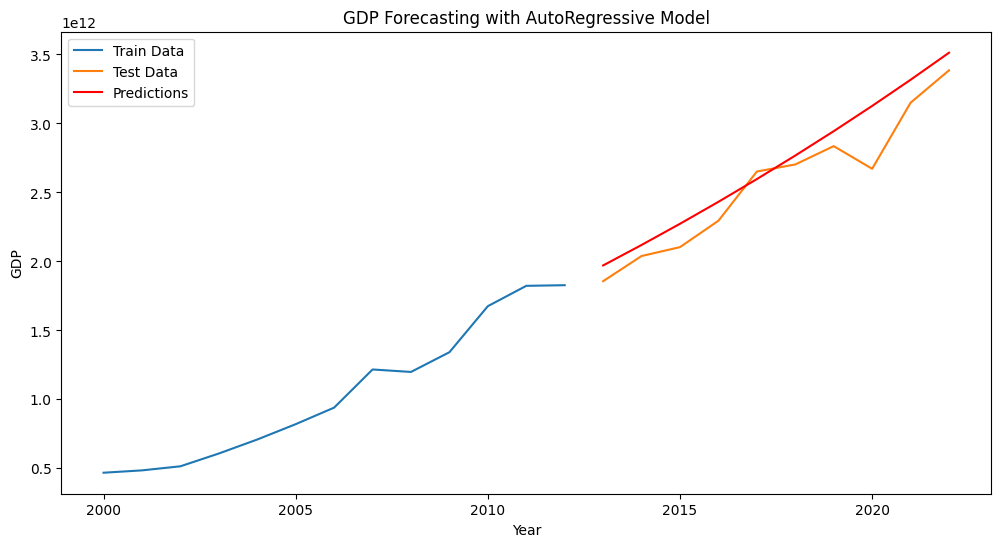

In [ ]:

df = gdp_india_df.toPandas()
# Ensure that 'Year' is set as the index
df.set_index('Year', inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.6)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Define the lag order (number of lag observations to include)
lag_order = 1  # You can adjust this based on your data

# Fit the autoregressive model
model = AutoReg(train_data['GDP'], lags=lag_order)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Calculate Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(test_data['GDP'], predictions)
print("Mean Squared Error (MSE):", mse)

# Plot the original GDP and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['GDP'], label='Train Data')
plt.plot(test_data.index, test_data['GDP'], label='Test Data')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Forecasting with AutoRegressive Model')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score



# Calculate Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(test_data['GDP'], predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R^2 Score
r2 = r2_score(test_data['GDP'], predictions)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 3.3727614053010752e+22
Root Mean Squared Error (RMSE): 183650793771.79602
R^2 Score: 0.8460043034705647


#Trade Balance Prediction

Random Forest Regression

In [ ]:
#selecting features for net trade
selected_columns = ["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows", "Avg_Net_Trade"]
selected_data = avg_trade.select(selected_columns).na.drop()
selected_data = selected_data.filter((col("Country Name") != "India") & (col("Country Name") != "China"))

# Pipeline and Model Training
assembler = VectorAssembler(inputCols=["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows"], outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol="Avg_Net_Trade")
pipeline = Pipeline(stages=[assembler, rf])

param_grid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 50, 100, 200, 300])
    .addGrid(rf.maxDepth, [5, 10, 20, 30])
    .build()
)


evaluator = RegressionEvaluator(labelCol="Avg_Net_Trade", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
cv_model = cv.fit(selected_data)
best_rf_model = cv_model.bestModel

#Creating custom data for prediction

selected_countries = ["Nepal", "China", "United States", "Mexico", "Jordan"]
count = countries_df_with_mean.filter(col("Country Name").isin(selected_countries))
test1 = count.groupBy("Country Name").agg(*agg_exprs)
test_data = test1.select(selected_columns).na.drop()
c = ["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows", "Avg_Net_Trade","Country Name"]
pred = test1.select(c).na.drop()
custom_data_rows = test_data.select(selected_columns[:-1]).collect()
custom_data = spark.createDataFrame(custom_data_rows, selected_columns[:-1])

# Make predictions on the custom data
predicted_values = best_rf_model.transform(custom_data)

threshold = 0.0
predicted_values = predicted_values.withColumn("Trade Status", F.when(predicted_values["prediction"] > threshold, "Surplus").otherwise("Deficit"))

predicted_values = pred.join(predicted_values, on= ["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows"], how="left_outer")


rmse_rf = evaluator.evaluate(predicted_values)
mse_rf = evaluator.evaluate(predicted_values, {evaluator.metricName: "mse"})
mae_rf = evaluator.evaluate(predicted_values, {evaluator.metricName: "mae"})
r2_rf = evaluator.evaluate(predicted_values, {evaluator.metricName: "r2"})

predicted_values.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+------------+
|          Avg_Export|          Avg_Import|Avg_FDI_net_outflows|     Avg_Tax_revenue| Avg_FDI_net_inflows|       Avg_Net_Trade| Country Name|            features|          prediction|Trade Status|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+------------+
|1.198134519944847...|1.870337876173375...|2.0165871763455935E7| 8.679274135306314E9|1.5014816394225633E9|-6.722033562285281E9|       Jordan|[1.19813451994484...|-9.857693082349437E8|     Deficit|
|1.896116133497187...|2.487998214687067...|2.888512173913044E11|1.591658033883412...| 2.82076347826087E11|-5.91882081189879...|United States|[1.89611613349718...|-1.14424213782044...|     Deficit|
|1.766064899252

In [ ]:
print("Root Mean Squared Error (RMSE) on the test set: rmse_rf", rmse_rf)
print("Mean Squared Error (MSE) on the test set: mse_rf", mse_rf)
print("Mean Average Error(MAE) on the test set: mae_rf", mae_rf)
print("r2_rf value", r2_rf)


Root Mean Squared Error (RMSE) on the test set: rmse_rf 259430984468.9428
Mean Squared Error (MSE) on the test set: mse_rf 6.730443570252485e+22
Mean Average Error(MAE) on the test set: mae_rf 167399492125.30695
r2_rf value 0.07496620455705505


In [ ]:
# Convert PySpark DataFrames to Pandas DataFrames
result = predicted_values.toPandas()


In [ ]:
#true values vs predicted values for random forest model
import plotly.graph_objects as go

x = 'Avg_Net_Trade'
y = 'prediction'

error =  predicted_values.select(x,y).toPandas()

fig = px.scatter(error, x=x, y=y, labels={'x': 'True Values', 'y': 'Predicted Values'}, title='Scatter Plot with Diagonal Reference Line')

line_trace = go.Scatter(x=[error[x].min(), error[x].max()],
                        y=[error[y].min(), error[y].max()],
                        mode='lines', line=dict(color='red', dash='dash'), name='Diagonal Line')

fig.add_trace(line_trace)


fig.update_layout(width=800, height=500)

fig.show()


Linear Regression with PCA

In [ ]:
#selecting features for net trade

selected_columns1 = ["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows", "Avg_Net_Trade"]
selected_data1 = avg_trade.select(selected_columns1).na.drop()
selected_data1 = selected_data1.filter((F.col("Country Name") != "India") & (F.col("Country Name") != "China"))

#PCA, Pipeline and model training
assembler_pca = VectorAssembler(
    inputCols=[ "Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows"],
    outputCol="features"
)

scaler_pca = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")


lr = LinearRegression(featuresCol="pca_features", labelCol="Avg_Net_Trade")

pipeline_with_pca = Pipeline(stages=[assembler_pca, scaler_pca, pca, lr])

param_grid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build()
)

evaluator_lr = RegressionEvaluator(labelCol="Avg_Net_Trade", predictionCol="prediction", metricName="rmse")


cv_lr = CrossValidator(estimator=pipeline_with_pca, estimatorParamMaps=param_grid_lr, evaluator=evaluator_lr, numFolds=3)
cv_model_with_pca = cv_lr.fit(selected_data1)
best_lr_model_with_pca = cv_model_with_pca.bestModel

#Creating custom data for prediction
selected_countries = ["Nepal", "China", "United States", "Mexico", "Jordan"]
count = countries_df_with_mean.filter(F.col("Country Name").isin(selected_countries))
test1 = count.groupBy("Country Name").agg(*agg_exprs)
test_data1 = test1.select(selected_columns1).na.drop()

c = ["Avg_Export", "Avg_Import", "Avg_FDI_net_outflows", "Avg_Tax_revenue", "Avg_FDI_net_inflows", "Avg_Net_Trade", "Country Name"]
pred = test1.select(c).na.drop()


custom_data_rows1 = test_data1.select(selected_columns1[:-1]).collect()
custom_data1 = spark.createDataFrame(custom_data_rows1, selected_columns1[:-1])



# Make predictions on the custom data
predicted_values_lr = best_lr_model_with_pca.transform(custom_data1)

threshold_lr = 0.0
predicted_values_lr = predicted_values_lr.withColumn("Trade Status", F.when(predicted_values_lr["prediction"] > threshold_lr, "Surplus").otherwise("Deficit"))
join_condition = [
    pred["Avg_Export"] == predicted_values_lr["Avg_Export"],
    pred["Avg_Import"] == predicted_values_lr["Avg_Import"],
    pred["Avg_FDI_net_outflows"] == predicted_values_lr["Avg_FDI_net_outflows"],
    pred["Avg_Tax_revenue"] == predicted_values_lr["Avg_Tax_revenue"],
    pred["Avg_FDI_net_inflows"] == predicted_values_lr["Avg_FDI_net_inflows"]
]

predicted_values_lr = pred.join(predicted_values_lr, on=join_condition, how="left_outer")



rmse_lr = evaluator_lr.evaluate(predicted_values_lr)
mse_lr = evaluator_lr.evaluate(predicted_values_lr, {evaluator_lr.metricName: "mse"})
mae_lr = evaluator_lr.evaluate(predicted_values_lr, {evaluator_lr.metricName: "mae"})
r2_lr = evaluator_lr.evaluate(predicted_values_lr, {evaluator_lr.metricName: "r2"})
predicted_values_lr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+
|          Avg_Export|          Avg_Import|Avg_FDI_net_outflows|     Avg_Tax_revenue| Avg_FDI_net_inflows|       Avg_Net_Trade| Country Name|          Avg_Export|          Avg_Import|Avg_FDI_net_outflows|     Avg_Tax_revenue| Avg_FDI_net_inflows|            features|     scaled_features|        pca_features|          prediction|Trade Status|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---

In [ ]:
print("Root Mean Squared Error (RMSE) on the test set: rmse_lr", rmse_lr)
print("Mean Squared Error (MSE) on the test set: mse_lr", mse_lr)
print("Mean Average Error(MAE) on the test set: mae_lr", mae_lr)
print("r2_lr value", r2_lr)


Root Mean Squared Error (RMSE) on the test set: rmse_lr 148025350882.0552
Mean Squared Error (MSE) on the test set: mse_lr 2.191150450375556e+22
Mean Average Error(MAE) on the test set: mae_lr 102133309545.20384
r2_lr value 0.6988477510671139


In [ ]:
#true values vs predicted values for random forest model

import plotly.graph_objects as go

x = 'Avg_Net_Trade'
y = 'prediction'

error2 =  predicted_values_lr.select(x,y).toPandas()

fig2 = px.scatter(error2, x=x, y=y, labels={'x': 'True Values', 'y': 'Predicted Values'}, title='Scatter Plot with Diagonal Reference Line')

line_trace2 = go.Scatter(x=[error2[x].min(), error2[x].max()],
                        y=[error2[y].min(), error2[y].max()],
                        mode='lines', line=dict(color='red', dash='dash'), name='Diagonal Line')

fig2.add_trace(line_trace2)


fig2.update_layout(width=800, height=500)

fig2.show()
